In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io

# from kinect_smoothing_test import HoleFilling_Filter, Denoising_Filter

In [2]:
mat = scipy.io.loadmat('cali/calibrationSession_ir.mat')
rgb_img = cv2.imread('test_img/rgb_38.png')[:,:,::-1]
depth_img = cv2.imread('test_img/depth_38.png',cv2.IMREAD_UNCHANGED)

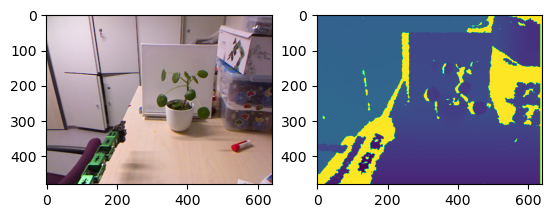

In [3]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(depth_img)

In [4]:
class camera():
    def __init__(self):
        self.ir_intrinsic_matrix = np.array(
            [[5.921210312948759e+02, 0, 3.282061975740925e+02],
             [0, 5.895050549620443e+02, 2.391036736260116e+02], [0, 0, 1]])
        self.ir_distortion_matrix = np.array(
            [-0.164791039922942, 0.623034953761724, 0, 0, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[5.278701517313602e+02, 0, 3.357713730312922e+02],
             [0, 5.253263705766253e+02, 2.471377927422452e+02], [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
            [0.227235410500697, -0.60503132813588, 0, 0, 0])

        self.A = np.array([[
            0.999955789203310, -0.00485634717811722, 0.00805205134552720,
            -24.8743671701814+2.5
        ],
                            [
                                0.00477322308179293, 0.999935451627946,
                                0.0103106216605492, 0.153988150169316+3
                            ],
                            [
                                -0.00810160355712699, -0.0102717315824129,
                                0.999914424113435, 0.345027154698123
                            ]])
        self.imgsz = [640, 480]
        return

    def rectify(self):

        return

    def undistortion(self, distorted_img, camera_type):
        # Correcting the distortion
        if camera_type == 'rgb':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.rgb_intrinsic_matrix, self.rgb_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img, self.rgb_intrinsic_matrix,
                self.rgb_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        elif camera_type == 'ir':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.ir_intrinsic_matrix, self.ir_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img.astype(np.float64), self.ir_intrinsic_matrix,
                self.ir_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        return undistorted_img, camera_matrix

In [5]:
kinect = camera()
# w = 640
# h = 480

rgb_img, mtx_rgb = kinect.undistortion(rgb_img,'rgb')
_, mtx_ir = kinect.undistortion(depth_img,'ir')
# mtx_rgb = kinect.rgb_intrinsic_matrix
# mtx_ir = kinect.ir_intrinsic_matrix

# objpoints = []
# R = kinect.A[:3,:3]
# t = kinect.A[:,3]
# result= \
#     cv2.stereoRectify(mtx_rgb,kinect.rgb_distortion_matrix, mtx_ir, kinect.ir_distortion_matrix, kinect.imgsz,R,t)   #再做双目标定



In [6]:
# dist = 0.1236 * np.tan((depth_img) / 2842.5 + 1.1863)*1000-37
# dist =  0.1236 * np.tan((depth_img) / 2842.5 + 1.1863)*1000

epsilon = 1e-5  # A small constant to avoid division by zero
dist = 0.075 * 590 / (1090 - depth_img) * 8*1000

# dist = 1/(depth_img*(-0.0030711016)+3.3309495161)*1000

dist[dist<200] = 0
dist[dist>800] = 0
depth_img.shape

(480, 640)

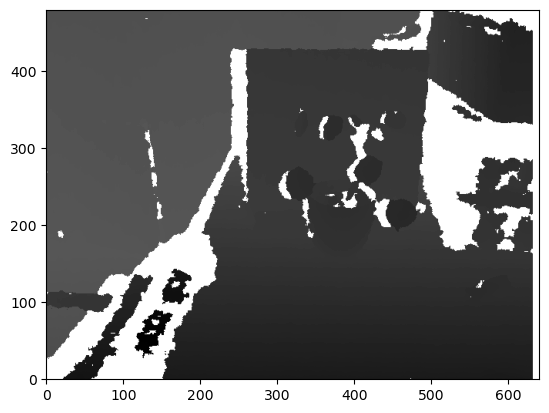

In [7]:
plt.imshow(depth_img, cmap='gray', extent=(0, depth_img.shape[1], 0, depth_img.shape[0]))
plt.gca().set_aspect('equal', adjustable='box')  # 保持纵横比相等

In [8]:
def pixel2world(x, y, intrinsic_matrix, dist):
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    Z = dist[y, x]
    X = (x - cx) * (Z) / fx
    Y = (y - cy) * (Z) / fy

    return X, Y, Z

In [9]:
x = np.tile(np.arange(640), (480, 1))
y = np.tile(np.arange(480).reshape(-1, 1), (1, 640))
X, Y, Z = pixel2world(x, y, mtx_ir, dist)
# Flatten the matrices
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Combine into a single array of 3D points
points_3d = np.vstack((X_flat, Y_flat, Z_flat)).T
# Remove rows where Z < 0
points_3d = points_3d[points_3d[:, 2] >= 0]

In [10]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize the point cloud
# o3d.visualization.draw_geometries([pcd,FOR1])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0).T

In [12]:
E = kinect.A
K = mtx_rgb
T_ir2rgb = K.dot(E)
raw_pixel = T_ir2rgb.dot(points_3d.T).T

In [13]:
rgb_pixel = np.round((raw_pixel/(raw_pixel[:,-1]).reshape(-1,1))).astype(int)

<Axes: ylabel='Frequency'>

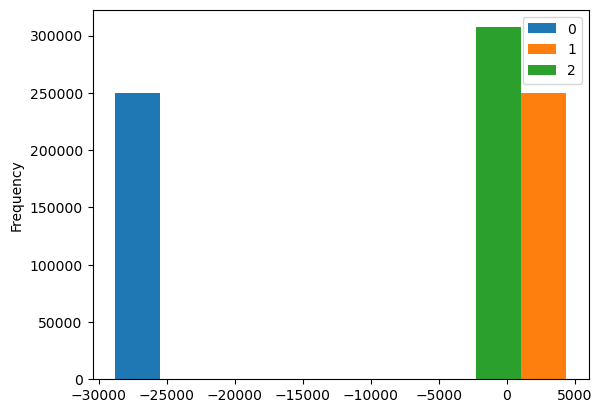

In [14]:
df_rgb_pixel = pd.DataFrame(rgb_pixel)
df_rgb_pixel.plot.hist()

In [15]:
h = points_3d.shape[0]
points_3d_color  = np.zeros((h,3))
for i,v in enumerate(points_3d):
    u,v = rgb_pixel[i][:2]
    if u>=640 or v>=480:
        pc =  np.array([np.nan,np.nan,np.nan])
    elif  u<0 or v<0:
        pc = np.array([np.nan,np.nan,np.nan])
    else:
        pc = rgb_img[v,u]
    points_3d_color[i] = pc
    

In [16]:
# Creating a point cloud object
pcd = o3d.geometry.PointCloud()

# points_3d[:,0] = points_3d[:,0]
# Assigning the points
pcd.points = o3d.utility.Vector3dVector(points_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1,0]]/ 255.0)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

In [93]:
downpcd = pcd.uniform_down_sample(every_k_points = 10)
# Visualizing the point cloud
o3d.visualization.draw_geometries([downpcd,FOR1])

In [98]:
plane_model, inliers = downpcd.segment_plane(distance_threshold=10,
                                         ransac_n=5000,
                                         num_iterations=10)

[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downpcd.select_by_index(inliers)
# plane_model, inliers = inlier_cloud.segment_plane(distance_threshold=50,
#                                          ransac_n=100,
#                                          num_iterations=100)
# inlier_cloud = inlier_cloud.select_by_index(inliers)

inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downpcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0])
o3d.visualization.draw_geometries([outlier_cloud])

Plane equation: 0.35x + 0.90y + -0.26z + -0.00 = 0


In [97]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        outlier_cloud.cluster_dbscan(eps=50, min_points=60, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
outlier_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([outlier_cloud])


[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters


In [20]:
np.asarray(outlier_cloud.points)
np.asarray(outlier_cloud.colors)


array([[0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       ...,
       [0.7372549 , 0.74117647, 0.13333333],
       [0.7372549 , 0.74117647, 0.13333333],
       [0.7372549 , 0.74117647, 0.13333333]])

In [21]:
# Remove radius outliers
cleaned_cloud = outlier_cloud.remove_radius_outlier(nb_points=10, radius=60)
cleaned_cloud = cleaned_cloud[0].random_down_sample(0.90)
# o3d.visualization.draw_geometries([cleaned_cloud])


In [22]:
import open3d as o3d

# Create a mesh from the point cloud using alpha shape
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cleaned_cloud, alpha=0.01)
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cleaned_cloud)

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    cleaned_cloud, 0.015*1000, tetra_mesh, pt_map)
mesh.compute_vertex_normals()

# o3d.visualization.draw_geometries([mesh])
# Save the mesh as a PLY file
o3d.io.write_triangle_mesh("point_cloud.ply", mesh)
import open3d as o3d

# 假设您的点云已经存储在变量 cloud 中，类型为 Open3D 的 PointCloud 对象

# 将点云转换为三角网格

# 计算三角网格的表面积
surface_area = mesh.compute_triangle_normals().get_surface_area()

print("点云的表面积为:", surface_area)

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

In [23]:
import open3d as o3d

# Assuming cleaned_cloud is your point cloud
# Compute normal vectors for the point cloud
cleaned_cloud.estimate_normals()

In [24]:
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cleaned_cloud)

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    cleaned_cloud, 0.015*1000, tetra_mesh, pt_map)
mesh.compute_vertex_normals()

# o3d.visualization.draw_geometries([mesh])

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

TriangleMesh with 3021 points and 6554 triangles.

In [25]:
plane_model, inliers = cleaned_cloud.segment_plane(distance_threshold=200,
                                         ransac_n=10,
                                         num_iterations=500)
inlier_cloud = cleaned_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = cleaned_cloud.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0])
# o3d.visualization.draw_geometries([inlier_cloud,outlier_cloud])

PointCloud with 0 points.

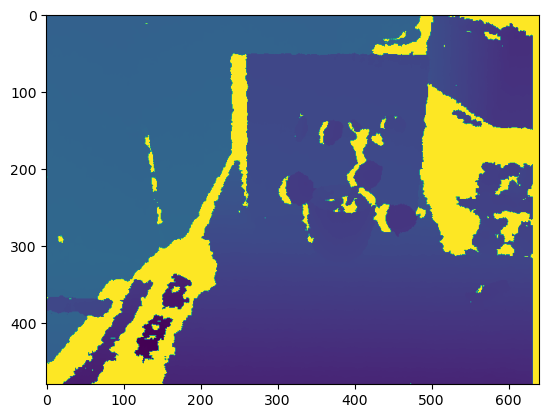

In [26]:
depth_img_new = depth_img>>2

plt.imshow(depth_img_new)
